# Empirically testing the normality hypothesis

In Hu & Lu, they show that when the covariates $z_i$ are Gaussian, the features $x_i$ are generated by a random features model, and the labels $y_i$ are given by 

$$y_i = \psi(\langle \theta^*, z_i \rangle),$$

then the features $x_i$ are asymptotically Gaussian and the joint distribution of $y_i$ with any one-dimensional projection of the features $x_i$ is jointly Gaussian.

Here, we empirically explore whether this normality holds more generally. If so, there is hope that a similar proof technique can be used to show universality under more general assumptions on the response function.

## Hu & Lu Setting

In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from universality_erm_utils import *
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### $\psi: x \mapsto x, \sigma_{RF}: x \mapsto \tanh(x)$

In [168]:
n = 6000
n_train = 1200
gamma = 1.5
eta = 0.5
d = 200
p = int(n_train * gamma)
nu = 0.5

psi = lambda x: x
rf_activation = np.tanh

z_mean = np.array([0]*d)
z_cov = np.identity(d)
Z = np.random.multivariate_normal(mean=z_mean, cov=z_cov, size=n)

## generate unknown model parameter
beta_star = np.random.normal(loc=0, scale=1, size=(d,1))
beta_star /= np.linalg.norm(beta_star, ord=2)

## generate response
epsilon = np.random.normal(loc=0, scale=nu, size=(n,1))
y = np.squeeze(psi(Z@beta_star + epsilon))

rfmodel_phi, W = get_rfmodel(d, p, rf_activation)

X = rfmodel_phi(Z)

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

#### $\theta \sim \text{Unif}(\mathbb{S}^{p-1})$

In [176]:
theta = np.random.normal(loc=0, scale=1, size=(p,1))
theta /= np.linalg.norm(theta, ord=2)

proj_X = np.squeeze(np.dot(X_test, theta))

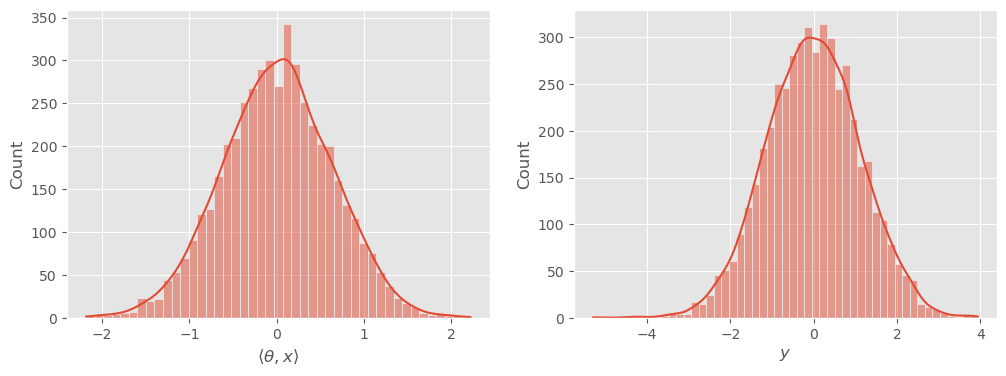

In [177]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [178]:
scipy.stats.normaltest(proj_X), scipy.stats.normaltest(y_test)

(NormaltestResult(statistic=1.145456603918744, pvalue=0.5639846174057113),
 NormaltestResult(statistic=2.8838559533549466, pvalue=0.23647140754766693))

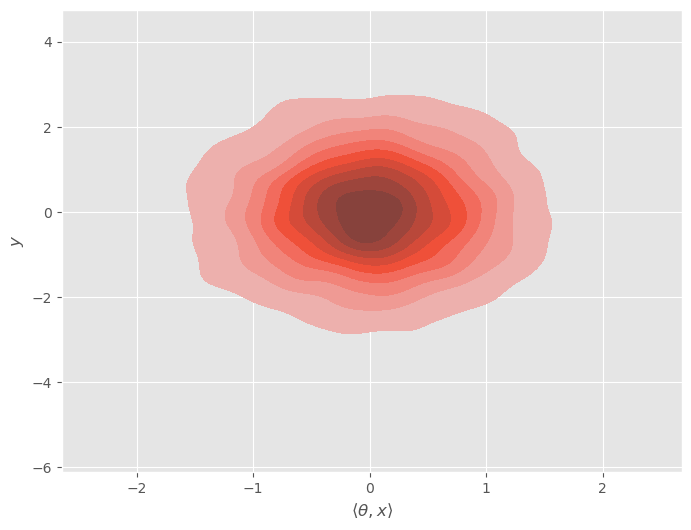

In [179]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

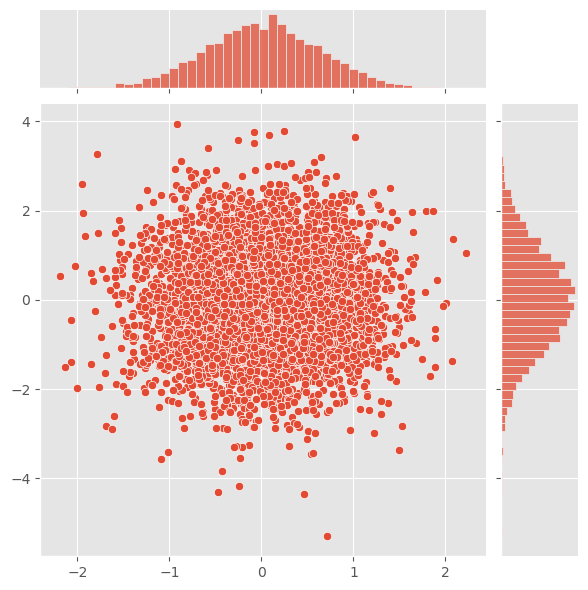

In [180]:
g = sns.jointplot(x=proj_X, y=y_test)

#### $\theta = \theta^*$ (mse-minimizer)

In [181]:
from sklearn.linear_model import LinearRegression
theta = LinearRegression(fit_intercept=False).fit(X_train, y_train).coef_
proj_X = np.squeeze(np.dot(X_test, theta))

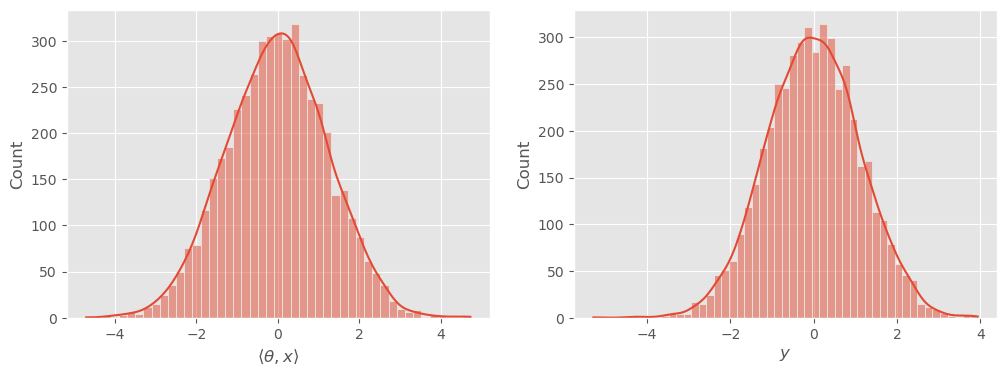

In [182]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [183]:
scipy.stats.normaltest(proj_X), scipy.stats.normaltest(y_test)

(NormaltestResult(statistic=0.16439785402268967, pvalue=0.9210887110460274),
 NormaltestResult(statistic=2.8838559533549466, pvalue=0.23647140754766693))

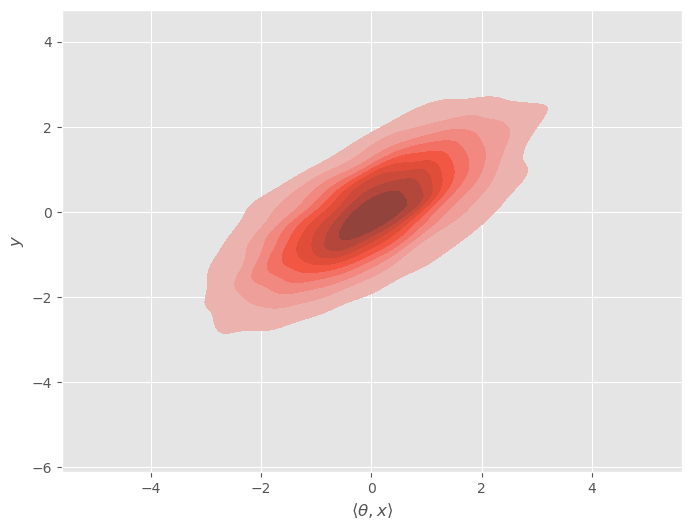

In [184]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

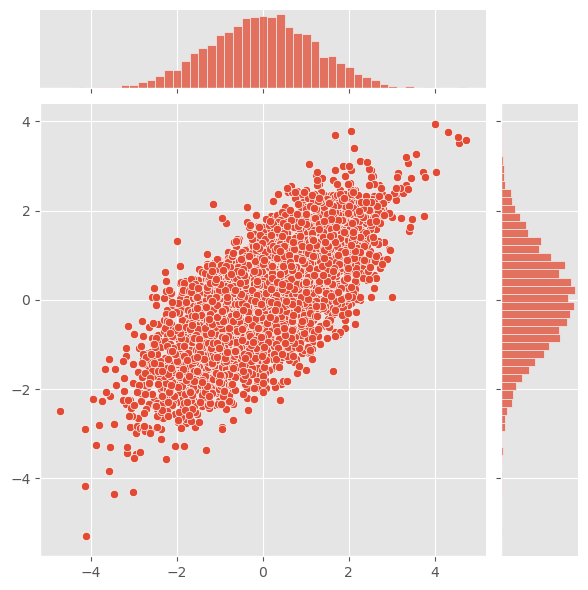

In [185]:
g = sns.jointplot(x=proj_X, y=y_test)

## with NeurNet Response Function

In [ ]:
rf_activation = np.tanh

z_mean = np.array([0]*d)
z_cov = np.identity(d)
Z = np.random.multivariate_normal(mean=z_mean, cov=z_cov, size=n)


## generate response

# ground truth response function to be predicted: y = NN(z) + noise

# generate random neural network response function
response_nn = tf.keras.Sequential(
    [
    tf.keras.layers.Dense(n_neurons, activation=response_nn_activation)
    for n_neurons in response_nn_layers] \
    + [tf.keras.layers.Dense(1, activation='linear')])

epsilon = np.random.normal(loc=0, scale=nu, size=(n,1))
y = response_nn(Z) + epsilon

### $\psi: x \mapsto x, \sigma_{NN}: x \mapsto \tanh(x)$

In [191]:
response_nn_layers = [128, 256, 128]
response_nn_activation = 'tanh'

n = 6000
n_train = 1200
gamma = 1.5
eta = 0.5
# d = int(n_train * eta)
d = 200
p = int(n_train * gamma)
nu = 0.5

psi = lambda x: x
rf_activation = np.tanh

z_mean = np.array([0]*d)
z_cov = np.identity(d)
Z = np.random.multivariate_normal(mean=z_mean, cov=z_cov, size=n)

# ground truth response function to be predicted: y = NN(z)
# generate random neural network response function
response_nn = tf.keras.Sequential(
    [
    tf.keras.layers.Dense(n_neurons, activation=response_nn_activation)
    for n_neurons in response_nn_layers] \
    + [tf.keras.layers.Dense(1, activation='linear')])

epsilon = np.random.normal(loc=0, scale=nu, size=(n,1))
y = np.squeeze(response_nn(Z) + epsilon)

rfmodel_phi, W = get_rfmodel(d, p, rf_activation)

X = rfmodel_phi(Z)

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

#### $\theta \sim \text{Unif}(\mathbb{S}^{p-1})$

In [192]:
theta = np.random.normal(loc=0, scale=1, size=(p,1))
theta /= np.linalg.norm(theta, ord=2)

proj_X = np.squeeze(np.dot(X_test, theta))

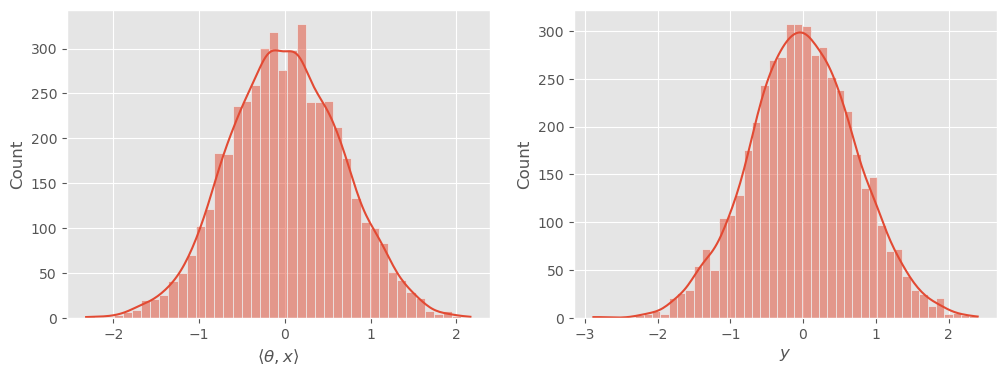

In [193]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [194]:
scipy.stats.normaltest(proj_X), scipy.stats.normaltest(y_test)

(NormaltestResult(statistic=4.279062848838176, pvalue=0.11770998612654243),
 NormaltestResult(statistic=0.05591592937614893, pvalue=0.9724292423086595))

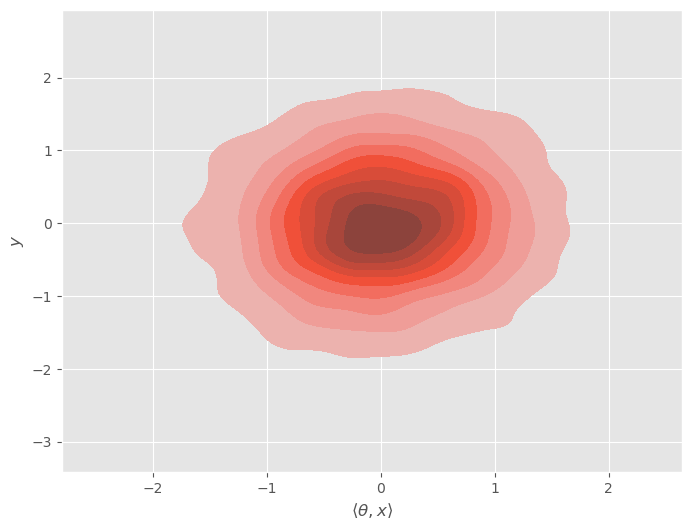

In [195]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

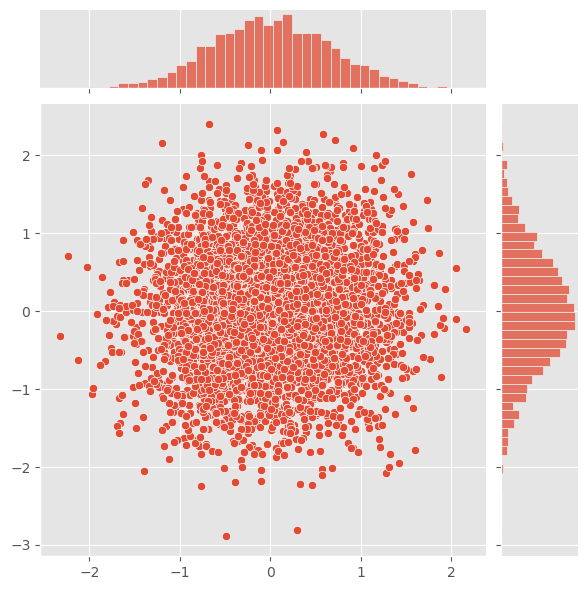

In [196]:
g = sns.jointplot(x=proj_X, y=y_test)

#### $\theta = \theta^*$ (mse-minimizer)

In [197]:
from sklearn.linear_model import LinearRegression
theta = LinearRegression(fit_intercept=False).fit(X_train, y_train).coef_
proj_X = np.squeeze(np.dot(X_test, theta))

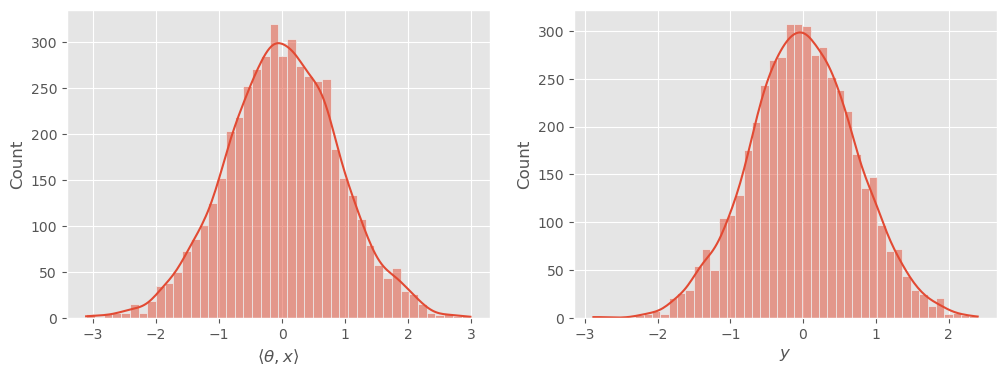

In [198]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [199]:
scipy.stats.normaltest(proj_X), scipy.stats.normaltest(y_test)

(NormaltestResult(statistic=1.5195550261339552, pvalue=0.46777048825463663),
 NormaltestResult(statistic=0.05591592937614893, pvalue=0.9724292423086595))

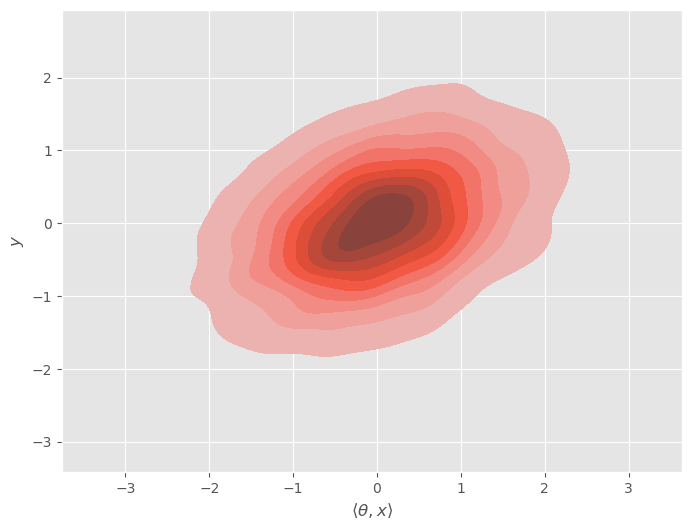

In [200]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

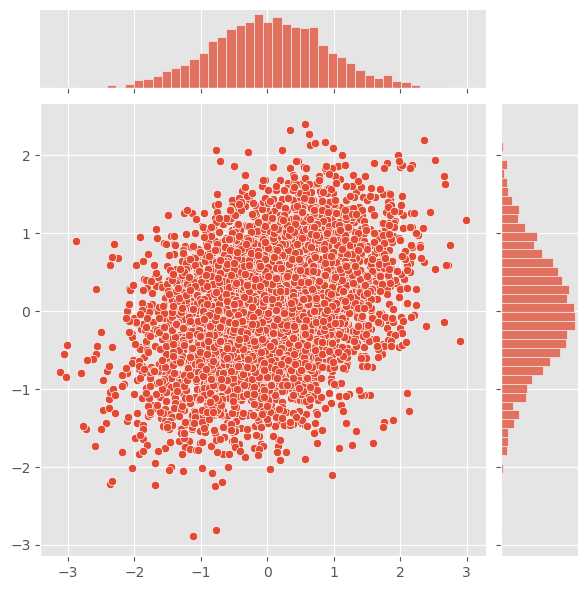

In [201]:
g = sns.jointplot(x=proj_X, y=y_test)